In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import TensorDataset, DataLoader


In [11]:
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\EXEMPTED\CODED\ML\T1\traffic flow\traffic.csv")
pivot = df.pivot(index='DateTime', columns='Junction', values='Vehicles')

pivot = pivot.fillna(method='ffill')   # forward fill
pivot = pivot.fillna(method='bfill')   # back fill (safety)

values = pivot.values



C:\Users\ASUS\AppData\Local\Temp\ipykernel_15320\2162875795.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot.fillna(method='ffill')   # forward fill
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15320\2162875795.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot.fillna(method='bfill')   # back fill (safety)


In [12]:
scaler = MinMaxScaler()
values = scaler.fit_transform(values)


In [13]:
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+1:i+seq_len+1])
    return np.array(X), np.array(y)

X, y = create_sequences(values, 24)


In [14]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [15]:
A = torch.tensor([
    [1,1,0,0],
    [1,1,1,0],
    [0,1,1,1],
    [0,0,1,1]
], dtype=torch.float32)

A = A / A.sum(dim=1, keepdim=True)


In [16]:
class GNNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, A):
        A_batch = A.unsqueeze(0).repeat(x.size(0),1,1)
        x = torch.bmm(A_batch, x.unsqueeze(-1)).squeeze(-1)
        return self.linear(x)


In [17]:
class GNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gnn1 = GNNLayer(4, 32)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(32, 4)

    def forward(self, x):
        seq = []
        for t in range(x.shape[1]):
            xt = x[:,t,:]
            xt = self.relu(self.gnn1(xt, A))
            xt = self.fc(xt)
            seq.append(xt.unsqueeze(1))
        return torch.cat(seq, dim=1)


In [18]:
model = GNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()

for epoch in range(30):
    total_loss = 0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    print("Epoch", epoch+1, "Loss", total_loss)


Epoch 1 Loss 7.334991267416626
Epoch 2 Loss 1.764623095630668
Epoch 3 Loss 1.3110073513817042
Epoch 4 Loss 1.241883453913033
Epoch 5 Loss 1.2026345579652116
Epoch 6 Loss 1.1715142176253721
Epoch 7 Loss 1.1421704210806638
Epoch 8 Loss 1.1037883196258917
Epoch 9 Loss 1.070601389510557
Epoch 10 Loss 1.0447111927205697
Epoch 11 Loss 1.01638036838267
Epoch 12 Loss 0.9935990826925263
Epoch 13 Loss 0.975533175165765
Epoch 14 Loss 0.9582831478910521
Epoch 15 Loss 0.9441069171298295
Epoch 16 Loss 0.9310730637516826
Epoch 17 Loss 0.9200675744796172
Epoch 18 Loss 0.908114833640866
Epoch 19 Loss 0.8996542464010417
Epoch 20 Loss 0.8917247352655977
Epoch 21 Loss 0.885432556620799
Epoch 22 Loss 0.8804624413605779
Epoch 23 Loss 0.875510822981596
Epoch 24 Loss 0.8719178874744102
Epoch 25 Loss 0.8689928672974929
Epoch 26 Loss 0.8662914377637208
Epoch 27 Loss 0.8648796350462362
Epoch 28 Loss 0.8633490586653352
Epoch 29 Loss 0.8621205983217806
Epoch 30 Loss 0.8609169328119606


In [19]:
model.eval()
preds, actual = [], []

with torch.no_grad():
    for batch_x, batch_y in loader:
        out = model(batch_x)
        preds.append(out.numpy())
        actual.append(batch_y.numpy())

preds = np.concatenate(preds)
actual = np.concatenate(actual)

preds = scaler.inverse_transform(preds.reshape(-1,4)).reshape(preds.shape)
actual = scaler.inverse_transform(actual.reshape(-1,4)).reshape(actual.shape)

mae = mean_absolute_error(actual.flatten(), preds.flatten())
rmse = np.sqrt(mean_squared_error(actual.flatten(), preds.flatten()))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 2.622138023376465
RMSE: 4.39793553037346


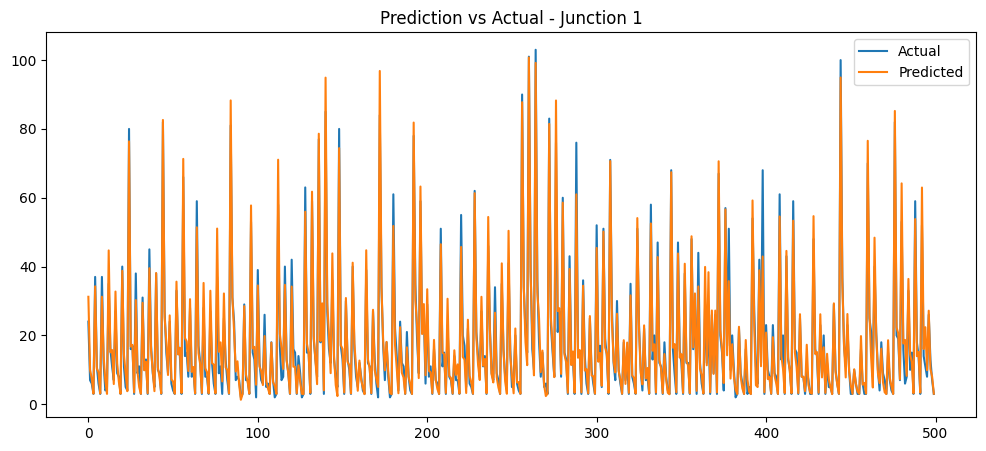

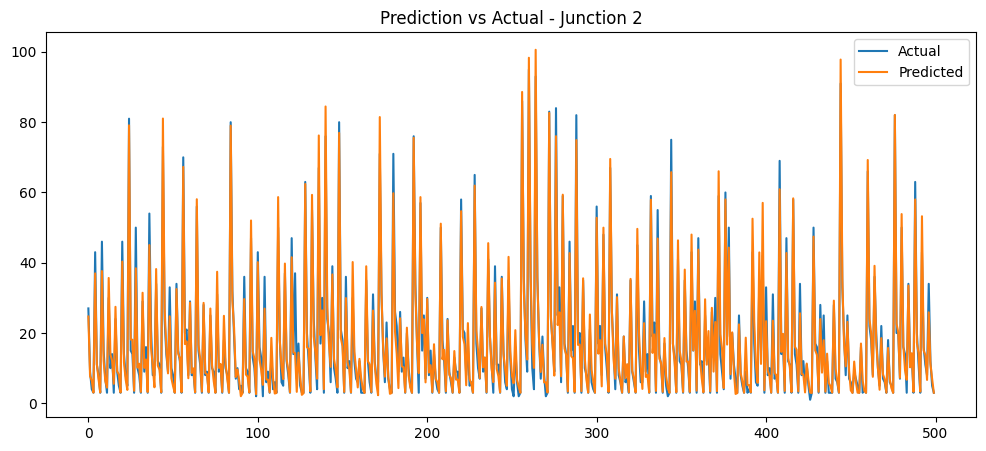

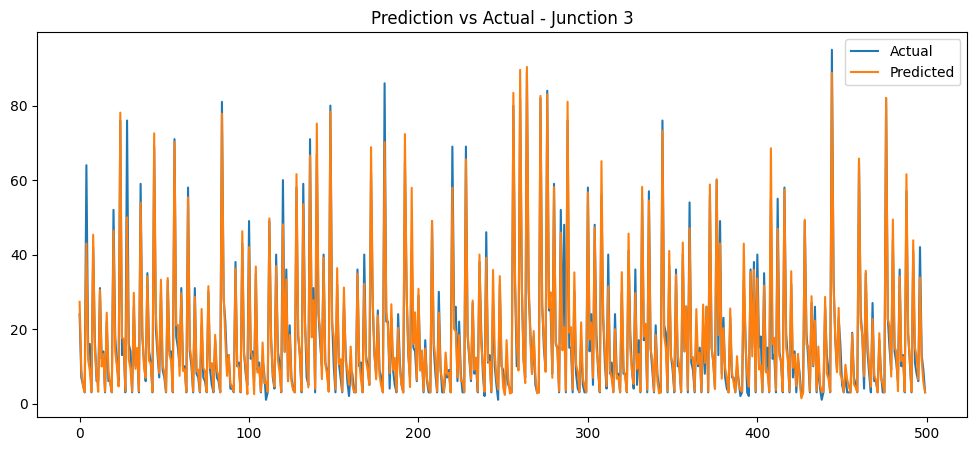

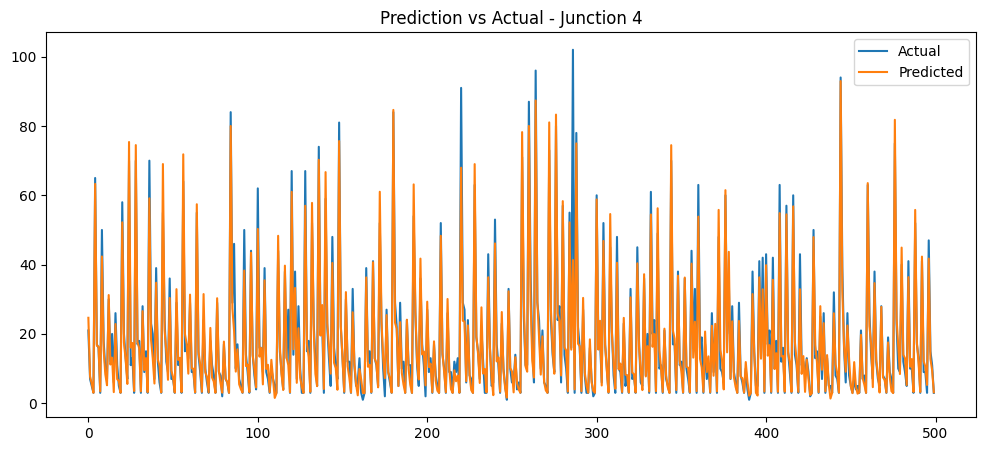

In [21]:
for i in range(4):
    plt.figure(figsize=(12,5))
    plt.plot(actual[:,i].flatten()[:500], label="Actual")
    plt.plot(preds[:,i].flatten()[:500], label="Predicted")
    plt.title(f"Prediction vs Actual - Junction {i+1}")
    plt.legend()
    plt.show()


In [22]:
class GNNLayer(nn.Module):
    def __init__(self, num_nodes):
        super().__init__()
        self.linear = nn.Linear(num_nodes, num_nodes)

    def forward(self, x, A):
        A_batch = A.unsqueeze(0).repeat(x.size(0),1,1)
        x = torch.bmm(A_batch, x.unsqueeze(-1)).squeeze(-1)
        return self.linear(x)


In [23]:
class GNN_LLM(nn.Module):
    def __init__(self):
        super().__init__()

        self.gnn = GNNLayer(4)
        self.relu = nn.ReLU()

        self.input_proj = nn.Linear(4, 128)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)

        self.fc = nn.Linear(128, 4)

    def forward(self, x):
        seq = []
        for t in range(x.shape[1]):
            xt = x[:,t,:]
            xt = self.relu(self.gnn(xt, A))
            seq.append(xt.unsqueeze(1))

        x = torch.cat(seq, dim=1)

        x = self.input_proj(x)
        x = self.transformer(x)

        return self.fc(x)


In [24]:
model = GNN_LLM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()

for epoch in range(40):
    total_loss = 0
    for batch_x, batch_y in loader:

        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        total_loss += loss.item()

    print("Epoch", epoch+1, "Loss", total_loss)


Epoch 1 Loss 4.977036343887448
Epoch 2 Loss 1.4110573050566018
Epoch 3 Loss 1.2564328954322264
Epoch 4 Loss 1.1322538853855804
Epoch 5 Loss 1.001718551502563
Epoch 6 Loss 0.9065205298829824
Epoch 7 Loss 0.8715544929727912
Epoch 8 Loss 0.8404823741875589
Epoch 9 Loss 0.7991473382571712
Epoch 10 Loss 0.7843454796238802
Epoch 11 Loss 0.7619689967250451
Epoch 12 Loss 0.753848476218991
Epoch 13 Loss 0.7342179720290005
Epoch 14 Loss 0.7289742593420669
Epoch 15 Loss 0.7135531376115978
Epoch 16 Loss 0.708015096723102
Epoch 17 Loss 0.6964585672831163
Epoch 18 Loss 0.6845165090053342
Epoch 19 Loss 0.6800248306244612
Epoch 20 Loss 0.6754823299124837
Epoch 21 Loss 0.6630413483362645
Epoch 22 Loss 0.6723312167450786
Epoch 23 Loss 0.6568762214155868
Epoch 24 Loss 0.6465094842715189
Epoch 25 Loss 0.6420501850661822
Epoch 26 Loss 0.6358903171494603
Epoch 27 Loss 0.63267258903943
Epoch 28 Loss 0.6294118650257587
Epoch 29 Loss 0.6207076369319111
Epoch 30 Loss 0.6228335614432581
Epoch 31 Loss 0.614679061

In [25]:
model.eval()
preds, actual = [], []

with torch.no_grad():
    for batch_x, batch_y in loader:
        out = model(batch_x)
        preds.append(out.numpy())
        actual.append(batch_y.numpy())

preds = np.concatenate(preds)
actual = np.concatenate(actual)

preds = scaler.inverse_transform(preds.reshape(-1,4)).reshape(preds.shape)
actual = scaler.inverse_transform(actual.reshape(-1,4)).reshape(actual.shape)


In [26]:
mae = mean_absolute_error(actual.flatten(), preds.flatten())
rmse = np.sqrt(mean_squared_error(actual.flatten(), preds.flatten()))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 2.1699817180633545
RMSE: 3.554754570967517


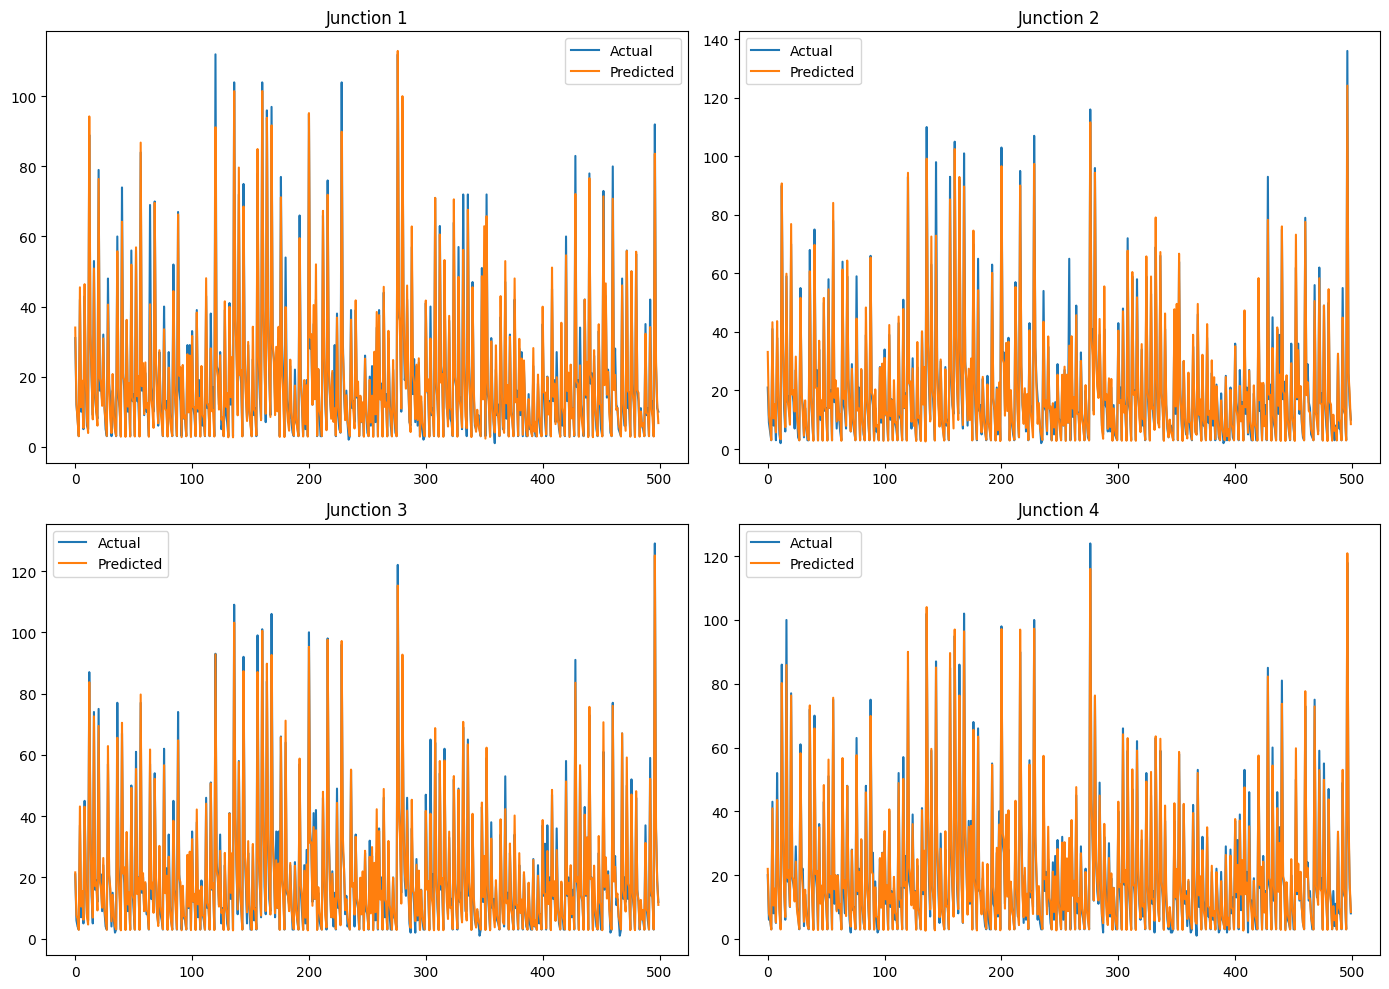

In [27]:
junctions = ["Junction 1","Junction 2","Junction 3","Junction 4"]

plt.figure(figsize=(14,10))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(actual[:,i].flatten()[:500], label="Actual")
    plt.plot(preds[:,i].flatten()[:500], label="Predicted")
    plt.title(junctions[i])
    plt.legend()

plt.tight_layout()
plt.show()
